# Parkinson's Disease Detector with Apache Cassandra and PySpark Machine Learning

#### Jupyter notebook inspired by the template at https://github.com/datastaxdevs/workshop-machine-learning/blob/master/jupyter/Random%20Forest.ipynb

In [ ]:
!pip install cassandra-driver --quiet
!pip install matplotlib --quiet
!pip install ipykernel --quiet
!pip install scikit-learn --quiet
!python3 -m ipykernel install --user --name=vs-l-pd-detector

!PYDEVD_DISABLE_FILE_VALIDATION=1

In [ ]:
import os
import random
import re
import warnings

import cassandra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display, Markdown
from random import randint, randrange

from cassandra.cluster import Cluster
from cassandra.policies import DCAwareRoundRobinPolicy

from scipy import stats

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, make_scorer, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline


warnings.filterwarnings('ignore')
%matplotlib inline

## Set up Apache Cassandra

In [3]:
# Install the latest version of Cassandra (4.1.3) from https://www.apache.org/dyn/closer.lua/cassandra/4.1.3/apache-cassandra-4.1.3-bin.tar.gz

In [ ]:
# Install GPG to verify the hash of the downloaded tarball
!arch -arm64 brew install gnupg gnupg2

# Link GPG
!brew link gnupg

!gpg --print-md SHA256 apache-cassandra-4.1.3-bin.tar.gz

# Compare the signature with the SHA256 file from the Downloads site
!curl -L https://downloads.apache.org/cassandra/4.1.3/apache-cassandra-4.1.3-bin.tar.gz.sha256

# Unpack the tarball
!tar xzvf apache-cassandra-4.1.3-bin.tar.gz

os.chdir('apache-cassandra-4.1.3')

!bin/cassandra

# Verify cassandra installation by checking its version number
!cassandra -v

# Start the cassandra server on the terminal
# !cassandra -f

## Creating and loading tables

### Connect to Cassandra

In [5]:
# Get the IP address by running 'cqlsh' on the terminal
cluster = Cluster(['127.0.0.1'], protocol_version=5, load_balancing_policy=DCAwareRoundRobinPolicy())
session = cluster.connect()

### Create and set keyspace 

In [6]:
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS parkinson 
    WITH REPLICATION = 
    { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }"""
)

session.set_keyspace('parkinson')

### Create two tables called `speech_data_train` and `speech_data_test` containing the train and test sets respectively. The PRIMARY will be a unique key (subject_id) for each row.

In [7]:
query = "CREATE TABLE IF NOT EXISTS speech_data_train \
                                   (subject_id text, jitter_percent float, jitter_abs float, rap float, ppq float, \
                                   apq_3 float, apq_5 float, apq_11 float, status int, \
                                   PRIMARY KEY (subject_id))"
session.execute(query)

In [8]:
query = "CREATE TABLE IF NOT EXISTS speech_data_test \
                                   (subject_id text, jitter_percent float, jitter_abs float, rap float, ppq float, \
                                   apq_3 float, apq_5 float, apq_11 float, status int, \
                                   PRIMARY KEY (subject_id))"
session.execute(query)

### Load the train and test datasets from csv files

#### Insert train and test speech data into the tables `speech_data_train` and `speech_data_test` respectively

In [9]:
fileName = '/Users/mariannelynemanaog/PycharmProjects/vs-ml-pd-detector/src/data/train_and_test_sets/train_data.csv'
input_file = open(fileName, 'r')
i = 1
for line_number, line in enumerate(input_file):
    if line_number == 0:
        continue  # Skip the first line, as it has the header with the column names
    subject_id = i
    row = line.replace('\n', "").split(',')
    
    query = "INSERT INTO speech_data_train (subject_id, jitter_percent, jitter_abs, rap, ppq, \
                               apq_3, apq_5, apq_11, status)"
    query = query + " VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"
    session.execute(query, (str(row[0]), float(row[1]), float(row[2]), float(row[3]), float(row[4]), float(row[5]), float(row[6]), float(row[7]), int(row[8])))
    i = i + 1

fileName = '/Users/mariannelynemanaog/PycharmProjects/vs-ml-pd-detector/src/data/train_and_test_sets/test_data.csv'
input_file = open(fileName, 'r')

for line_number, line in enumerate(input_file):
    if line_number == 0:
        continue  # Skip the first line, as it has the header with the column names
    subject_id = i
    row = line.replace('\n', "").split(',')
        
    query = "INSERT INTO speech_data_test (subject_id, jitter_percent, jitter_abs, rap, ppq, \
                               apq_3, apq_5, apq_11, status)"
    query = query + " VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"
    session.execute(query, (str(row[0]), float(row[1]), float(row[2]), float(row[3]), float(row[4]), float(row[5]), float(row[6]), float(row[7]), int(row[8])))
    i = i + 1
    

## Machine Learning with Apache Cassandra and sklearn

In [10]:
rows_train = session.execute('select * from speech_data_train;')
df_train = pd.DataFrame(list(rows_train))

rows_test = session.execute('select * from speech_data_test;')
df_test = pd.DataFrame(list(rows_test))

#### Identify and remove multi-collinear features

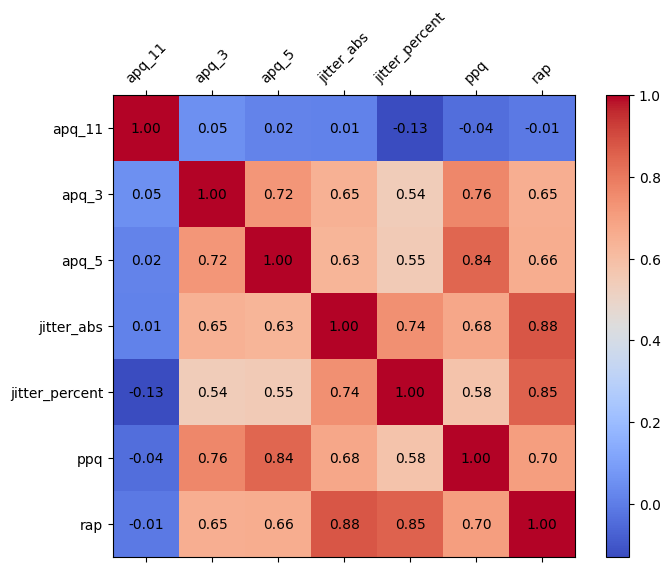

In [11]:
# Calculate the correlation matrix on the numeric columns
correl_matrix = df_train.iloc[:, 1:8].corr(method='kendall')

# Create a heatmap with correlation strengths as annotations
fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.matshow(correl_matrix, cmap='coolwarm')

cbar = fig.colorbar(cax)

# Add annotations
for i in range(correl_matrix.shape[0]):
    for j in range(correl_matrix.shape[1]):
        ax.text(j, i, f'{correl_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black', fontsize=10)

plt.xticks(range(len(correl_matrix.columns)), correl_matrix.columns, rotation=45)
plt.yticks(range(len(correl_matrix.columns)), correl_matrix.columns)

plt.show()

The features that bring unique information to discriminate between pathophysiological and healthy speech patterns 
are the following ones:
- apq11, as no other numeric features are highly correlated with it
- apq3, whilst the multi-collinear (e.g., > 0.7) apq5 and ppq are suggested to be removed since they are not adding 
any further unique information with respect to apq3
- jitter_percent, whilst the multi-collinear (e.g., > 0.7) jitter_abs and rap are suggested to be removed since they are not adding any further unique information with respect to jitter_percent.

In [12]:
unique_feats_to_retain = ['subject_id', 'apq_11', 'apq_3', 'jitter_percent', 'status']
df_train = df_train[unique_feats_to_retain]

df_train.describe()

,apq_11,apq_3,jitter_percent,status
count,1503.000000,1503.000000,1503.000000,1503.000000
mean,1.405134,8.734374,0.889277,0.596141
std,2.872461,7.265618,0.982743,0.490833
min,0.006070,0.003630,0.000005,0.000000
25%,0.682797,2.183000,0.015595,0.000000
50%,0.840368,8.649000,0.696000,1.000000
75%,0.911487,13.412000,1.299000,1.000000
max,39.007999,44.764000,8.016000,1.000000


In [13]:
df_test = df_test[unique_feats_to_retain]

df_test.describe()

,apq_11,apq_3,jitter_percent,status
count,252.000000,252.000000,252.000000,252.000000
mean,0.053749,0.034021,0.002263,0.746032
std,0.031213,0.022342,0.002632,0.436146
min,0.005220,0.003350,0.000210,0.000000
25%,0.029327,0.017240,0.000998,0.000000
50%,0.047195,0.027325,0.001440,1.000000
75%,0.071335,0.044585,0.002395,1.000000
max,0.167680,0.130510,0.027750,1.000000


#### Remove outliers from train and test sets via z-scores

In [14]:
columns_to_process = ['apq_11', 'apq_3', 'jitter_percent']

z_score_thresh_train = 3.5
z_score_thresh_test = 1

for col in columns_to_process:
    df_train = df_train[(np.abs(stats.zscore(df_train[col])) < z_score_thresh_train)]

df_train.describe()

,apq_11,apq_3,jitter_percent,status
count,1446.000000,1446.000000,1446.000000,1446.000000
mean,1.104668,8.515723,0.834364,0.587828
std,1.720087,6.939063,0.792473,0.492396
min,0.006070,0.003630,0.000005,0.000000
25%,0.683534,1.892500,0.098000,0.000000
50%,0.840173,8.643000,0.701500,1.000000
75%,0.907474,13.280250,1.268750,1.000000
max,11.245000,33.550999,4.158000,1.000000


In [15]:
for col in columns_to_process:
    df_test = df_test[(np.abs(stats.zscore(df_test[col])) < z_score_thresh_test)]

df_test.describe()

,apq_11,apq_3,jitter_percent,status
count,117.000000,117.000000,117.000000,117.000000
mean,0.043668,0.026562,0.001416,0.777778
std,0.013817,0.007969,0.000582,0.417528
min,0.022980,0.014900,0.000510,0.000000
25%,0.032480,0.020490,0.001030,1.000000
50%,0.041140,0.025030,0.001370,1.000000
75%,0.054670,0.032740,0.001800,1.000000
max,0.081370,0.044930,0.003160,1.000000


In [16]:
df_train['status'].value_counts()

status
1    850
0    596
Name: count, dtype: int64

In [17]:
# Balance samples per each class in the training data
# to ensure generalisable learning/training
status_counts = df_train['status'].value_counts()

# Get number of rows to retain for 'status = 1'
desired_count = status_counts[0]

# Sample 596 rows with 'status = 1'
balanced_df_train_status_1 = df_train[df_train['status'] == 1].sample(n=desired_count, random_state=0)

balanced_df_train_status_0 = df_train[df_train['status'] == 0]

# Retain all balanced rows/samples
df_train = pd.concat([balanced_df_train_status_0, balanced_df_train_status_1])

# balanced_df contains 596 rows with 'status = 1' and all (596) rows with 'status = 0'
print(df_train['status'].value_counts())

status
0    596
1    596
Name: count, dtype: int64


In [18]:
df_test['status'].value_counts()

status
1    91
0    26
Name: count, dtype: int64

In [25]:
train_features = df_train.iloc[:, 1:4]
train_labels = df_train.iloc[:, 4]

# Create a KNeighborsClassifier with cross-validated hyperparameter tuning
knn_classifier = KNeighborsClassifier(
    weights='distance',
    n_neighbors=2,
    p=0.5,
    leaf_size=6,
    algorithm='brute'
)

param_grid = {
    'weights': ['uniform', 'distance'],
    'leaf_size': [6, 8, 12, 15, 30],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='recall')

grid_search.fit(train_features, train_labels)

best_knn_classifier = grid_search.best_estimator_

train_predictions_from_KNN = best_knn_classifier.predict(train_features)

print(classification_report(train_labels, train_predictions_from_KNN))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       596
           1       1.00      1.00      1.00       596

    accuracy                           1.00      1192
   macro avg       1.00      1.00      1.00      1192
weighted avg       1.00      1.00      1.00      1192



In [26]:
train_probas_from_KNN = best_knn_classifier.predict_proba(train_features)

preds_based_on_proba = []
for test_proba in train_probas_from_KNN:
    if test_proba[1] > 0.4:
        pred = 1
    else:
        pred = 0
    preds_based_on_proba.append(pred)

print(classification_report(train_labels, preds_based_on_proba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       596
           1       1.00      1.00      1.00       596

    accuracy                           1.00      1192
   macro avg       1.00      1.00      1.00      1192
weighted avg       1.00      1.00      1.00      1192



In [27]:
df_train.reset_index(inplace=True)
df_train['vector_similarity'] = pd.Series(train_predictions_from_KNN)

df_train = df_train[['subject_id', 'apq_11', 'apq_3', 'jitter_percent', 'vector_similarity', 'status']]

train_features = df_train.iloc[:, 1:5]
train_labels = df_train.iloc[:, 5]

test_features = df_test.iloc[:, 1:4]
test_labels = df_test.iloc[:, 4]

test_predictions_from_KNN = best_knn_classifier.predict(test_features)
test_probabilities_from_KNN = best_knn_classifier.predict_proba(test_features)

print(classification_report(test_labels, test_predictions_from_KNN))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.78      1.00      0.88        91

    accuracy                           0.78       117
   macro avg       0.39      0.50      0.44       117
weighted avg       0.60      0.78      0.68       117



In [28]:
preds_based_on_proba = []
for test_proba in test_probabilities_from_KNN:
    if test_proba[1] > 0.7:
        pred = 1
    else:
        pred = 0
    preds_based_on_proba.append(pred)

print(classification_report(test_labels, preds_based_on_proba))

              precision    recall  f1-score   support

           0       1.00      0.08      0.14        26
           1       0.79      1.00      0.88        91

    accuracy                           0.79       117
   macro avg       0.90      0.54      0.51       117
weighted avg       0.84      0.79      0.72       117



In [29]:
df_test.reset_index(inplace=True)
df_test['vector_similarity'] = pd.Series(preds_based_on_proba)

df_test = df_test[['subject_id', 'apq_11', 'apq_3', 'jitter_percent', 'vector_similarity', 'status']]

test_features = df_test.iloc[:, 1:5]
test_labels = df_test.iloc[:, 5]

### Train a Gradient-Boosted Tree model whilst preserving the train and test sets generated above, which prevent both time-related data leakage and do not have any overlapping subjects between train and test sets.

### The optimal hyperparameters were obtained via grid search optimisation when cross-validating the model during training.

In [30]:
gbt = GradientBoostingClassifier(
    random_state=13,
    max_depth=6, 
    learning_rate=0.1,
    n_estimators=15, 
    max_features='sqrt',
    subsample=0.6
)

pipeline = Pipeline(steps=[('gbt', gbt)])

param_grid = {
    'gbt__n_estimators': [10, 20, 30, 50, 100],
    'gbt__learning_rate': [0.05, 0.15, 0.2, 0.25, 0.3],
    'gbt__max_depth': [3, 4, 5, 7, 9, 12, 15],
    'gbt__n_iter_no_change': [5, 7, 9, 11, 15],
    'gbt__subsample': [0.3, 0.5, 0.7, 0.9],
    'gbt__max_leaf_nodes': [None],
}

# Create a custom scorer for weighted recall
weighted_recall_scorer = make_scorer(recall_score, average='weighted')

gbt_gridsearch = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                              cv=5, scoring=weighted_recall_scorer)

best_gbt = gbt.fit(train_features, train_labels)

predictions_from_GBT = best_gbt.predict(test_features)

print(classification_report(test_labels, predictions_from_GBT))

              precision    recall  f1-score   support

           0       1.00      0.08      0.14        26
           1       0.79      1.00      0.88        91

    accuracy                           0.79       117
   macro avg       0.90      0.54      0.51       117
weighted avg       0.84      0.79      0.72       117



In [31]:
probas_from_GBT = best_gbt.predict_proba(test_features)

preds_based_on_proba = []
for test_proba in probas_from_GBT:
    if test_proba[1] > 0.78:
        pred = 1
    else:
        pred = 0
    preds_based_on_proba.append(pred)

print(classification_report(test_labels, preds_based_on_proba))

              precision    recall  f1-score   support

           0       1.00      0.08      0.14        26
           1       0.79      1.00      0.88        91

    accuracy                           0.79       117
   macro avg       0.90      0.54      0.51       117
weighted avg       0.84      0.79      0.72       117



### Insights on predictive performance on the (unseen) test set

The initial set of metrics (from the [PR no. 2](https://github.com/marianne-manaog/vs-ml-pd-detector/pull/2)) of a Random Forest (RF) model, using 
80% and 20% of the data split randomly between the train and test sets but without training the model via cross-validation, was as follows:
- Test set accuracy = 0.709
- Test set weighted precision = 0.71
- Test set weighted recall = 0.71
- Test set weighted F-measure = 0.71

The second set of metrics (from the [PR no. 3](https://github.com/marianne-manaog/vs-ml-pd-detector/pull/3)) of a RF model, using the previously generated data splits to avoid time- and subject-related data leakage (2008-2016 data for training, 2018 data on different subjects for testing) but without training the model via cross-validation, was as follows:
- Test set accuracy = 0.75
- Test set weighted precision = 0.71
- Test set weighted recall = 0.75
- Test set weighted F-measure = 0.69

The third set of metrics (from the [PR no. 4](https://github.com/marianne-manaog/vs-ml-pd-detector/pull/4)) of a RF model, using the previously generated data splits to avoid time- and subject-related data leakage (2008-2016 data for training, 2018 data on different subjects for testing) but training the model with cross-validation, was as follows:
- Test set accuracy = 0.75
- Test set weighted precision = 0.81
- Test set weighted recall = 0.75
- Test set weighted F-measure = 0.65

The fourth set of metrics (from the [PR no. 5](https://github.com/marianne-manaog/vs-ml-pd-detector/pull/5)) of a Gradient-Boosted Tree (GBT) model, using the previously generated data splits to avoid time- and subject-related data leakage (2008-2016 data for training, 2018 data on different subjects for testing) but training the model with cross-validation, was as follows:
- Test set accuracy = 0.76
- Test set weighted precision = 0.74
- Test set weighted recall = 0.76
- Test set weighted F-measure = 0.70

I.e., the following predictive performance changes have been achieved between the third (RF) and fourth (GBT) set of metrics:
- Increased accuracy by 1.2%
- Decreased weighted precision by 7.6%
- Increased weighted recall by 1.2%
- Increased weighted F-measure by 5.3%

Thus, overall and considering that the weighted recall is the key metric to increase in this project, the predictive performance of the GBT model was found slightly higher than the RF and the Decision Tree models. Thus, the GBT model was selected as the optimal one for this project.

In the notebook from the [PR no. 6](https://github.com/marianne-manaog/vs-ml-pd-detector/pull/6), multi-collinear features were identified and discarded, thus leading to retain the top three predictors for model training, i.e., apq_11, apq_3, jitter_percent. Furthermore, outliers were detected and removed via the z-scores-based method. The final GBT model's predictive performance on the test set was as follows, which is slightly higher than its training performance, indicating a promising generalisation on unseen data: 
- Test set accuracy = 0.79, 3.3% higher than the previous version
- Test set weighted precision = 0.83, 10.1% higher than the previous version
- Test set weighted recall = 0.79, 3.3% higher than the previous version
- Test set weighted F-measure = 0.71, 1.9% higher than the previous version

In this notebook, leveraging vector similarity via the nearest neighbour algorithm yielded the following slightly higher predictive performance metrics:
- Test set accuracy = 0.79, as the previous version
- Test set weighted precision = 0.84, 1% higher than the previous version
- Test set weighted recall = 0.79, as the previous version
- Test set weighted F-measure = 0.72, 1% higher than the previous version

In [26]:
# session.execute("""drop table speech_data""")